#   Plot co-visibilty time of a source at two or more telescopes

In [1]:
from astropy.time import Time
from astroplan import download_IERS_A 
import pandas as pd

from astropy.coordinates import EarthLocation
from astroplan import Observer,FixedTarget
import astroplan
from astroplan.plots import plot_airmass,plot_altitude
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import common_timezones
import pyorbital

pd.set_option("display.max_rows", None, "display.max_columns", None)

%matplotlib inline

In [2]:
hydraA=FixedTarget.from_name("Hydra_A")   
#selecting target  - Hydra_A
Ra,Dec=hydraA.ra,hydraA.dec                 #Extracting RA and Dec  since not manually imputed 
print(hydraA,Ra, Dec)                                #Checking if correct values were loaded
HydraA_skycoord = SkyCoord('139d31m24.765s', '-12d05m43.99s', frame='icrs')

<FixedTarget "Hydra_A" at SkyCoord (ICRS): (ra, dec) in deg (139.52354583, -12.09555278)> 139d31m24.765s -12d05m43.99s


In [3]:
ctio = Observer.at_site("ctio", timezone = 'America/Santiago')


location_spt = EarthLocation.from_geodetic(90.0*u.deg,0.0*u.deg,2800*u.m)
spt= Observer(location=location_spt, name="South Pole Telescope", timezone='Pacific/Auckland')


print(spt)
kmtnet= Observer.at_site("Siding Spring Observatory", name='KMTNET',timezone = 'Australia/Sydney')

<Observer: name='South Pole Telescope',
    location (lon, lat, el)=(90.0 deg, 0.0 deg, 2800.000000000187 m),
    timezone=<DstTzInfo 'Pacific/Auckland' LMT+11:39:00 STD>>


In [4]:
start_obs = Time('2020-11-25 00:00:00')
end_obs= Time('2020-11-25 23:00:00')
delta_t = end_obs - start_obs
dt = start_obs + delta_t*np.linspace(0, 1,75)
dt_datetime = [x.datetime for x in dt]

In [5]:
#dt

In [6]:
#Airmasses at ctio

airmass_ctio=ctio.altaz(dt, hydraA).secz

masked_airmass_ctio = np.ma.array(airmass_ctio, mask=airmass_ctio < 1)

#Airmasses at kmtnet
airmass_kmtnet=kmtnet.altaz(dt,hydraA).secz
masked_airmass_kmtnet = np.ma.array(airmass_kmtnet, mask=airmass_kmtnet < 1)


#Airmasses at SPT
airmass_spt=spt.altaz(dt, hydraA).secz

masked_airmass_spt = np.ma.array(airmass_spt, mask=airmass_spt < 1)

In [7]:
#Finding the intersecting point

ndx = np.argwhere(np.diff(np.sign(masked_airmass_ctio - masked_airmass_kmtnet))).flatten()
ndx=ndx[0]
intersect=dt_datetime[ndx]
intersect

datetime.datetime(2020, 11, 25, 14, 17, 50, 270270)

#Getting the start of intersect

ind=np.where(df['kmtnet-airmass']<3)
index2=ind[0][0] #Indices of first occurance
covis_start=df['datetimes'][index2]
covis_start

In [ ]:

#Another method of getting the intersecting point 
#df['diff']=df['ctio-airmass']-df['kmtnet-airmass']
#idx=np.max(np.where((abs(round(df['diff'],1)==0.0))))

#mid_time=df['datetimes'][idx]
#mid_time

In [9]:
#airmass_spt

from astropy.coordinates import get_moon
#Generate moon positions 
moon_radec=[]
for i in dt:
    get_moon(i)
    moon_radec.append(get_moon(i))

    
#convert them to radec format   
radecs=[]
for i in moon_radec:
    c = SkyCoord(ra=i.ra, dec=i.dec)
    radecs.append(c.to_string('hmsdms'))
    
#Splitting them
radec2=[]
for e in radecs:
    radec2.append(e.split(' '))
    
    
#Conveting to degrees
moon_locs=[]
l=np.arange(0,len(radec2))
for i in (l):
    moon_locs.append(SkyCoord(radec2[i][0],radec2[i][1], frame='icrs'))

#Get seperations in degrees
sep=[]
for i in moon_locs:
    sep.append(HydraA_skycoord.separation(i).deg)
#making them numpy arrays
sep=np.array(sep)   

In [10]:
sunset_CT = ctio.sun_set_time(start_obs, which='nearest')
sunrise_CT = ctio.sun_rise_time(start_obs, which='nearest')

moonset_ctio = ctio.moon_set_time(start_obs, which='nearest')
moonrise_ctio = ctio.moon_rise_time(start_obs, which='next')
moonrise_ctio,moonset_ctio=moonrise_ctio.iso,moonset_ctio.iso


twilight_morning_ctio=ctio.twilight_morning_astronomical(start_obs, which='nearest')
twilight_evening_ctio=ctio.twilight_evening_astronomical(start_obs, which='nearest')
twilight_morning_ctio,twilight_evening_ctio=twilight_morning_ctio.iso,twilight_evening_ctio.iso

#KMTNET
sunset_kmtnet = kmtnet.sun_set_time(start_obs, which='nearest')
sunrise_kmtnet = kmtnet.sun_rise_time(start_obs, which='next')
sunset_kmtnet,sunrise_kmtnet=sunset_kmtnet.iso,sunrise_kmtnet.iso


moonset_kmtnet = kmtnet.moon_set_time(start_obs, which='nearest')
moonrise_kmtnet = kmtnet.moon_rise_time(start_obs, which='next')
moonrise_kmtnet,moonset_kmtnet=moonrise_kmtnet.iso,moonset_kmtnet.iso


twilight_morning_kmtnet=kmtnet.twilight_morning_astronomical(start_obs, which='nearest')
twilight_evening_kmtnet=kmtnet.twilight_evening_astronomical(start_obs, which='nearest')
twilight_morning_kmtnet,twilight_evening_kmtnet=twilight_morning_kmtnet.iso,twilight_evening_kmtnet.iso

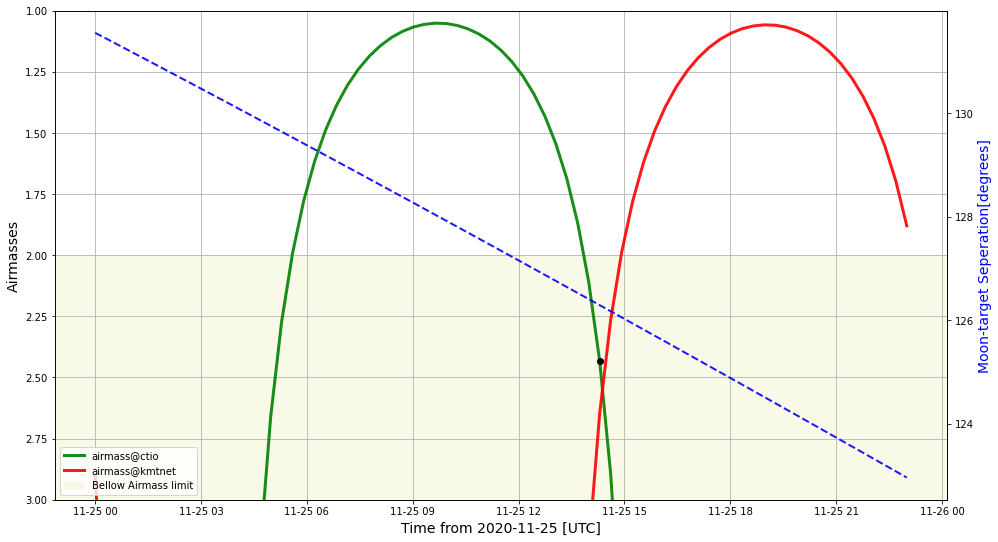

In [11]:
#Plotting


fig, ax = plt.subplots(figsize=(16,9))
ax.plot(dt_datetime, masked_airmass_ctio, label='airmass@ctio',color='g',linewidth=3, alpha=0.9)
ax.plot(dt_datetime, masked_airmass_kmtnet, color='r', label='airmass@kmtnet',linewidth=3, alpha=0.9)
ax.invert_yaxis()
ax.set_ylim([3,1])
ax.set_ylabel('Airmasses', color='k',fontsize=14)
ax.set_xlabel("Time from {0} [UTC]".format(min(dt_datetime).date()),fontsize=14)









ax2 = ax.twinx()
ax.axhspan(3, 2, facecolor='y', alpha=0.09,label='Bellow Airmass limit')
ax2.plot(dt_datetime, sep, color='b',linestyle='--', label='moon_sep',linewidth=2, alpha=0.9)
ax.legend(loc='lower left',prop={'size': 10})
ax2.set_ylabel('Moon-target Seperation[degrees]',color='b',fontsize=14)
ax.grid()






#plotting intersect
ax.plot(dt_datetime[ndx], masked_airmass_ctio[ndx], 'ko')


#Calculating co visibilities
date_1=covis_start

date_2=intersect

# returns a timedelta object 
delta = date_2-date_1
print('Difference: ', delta) 
  
mins = delta.total_seconds() / 60
print('Total difference in minutes: ',str(mins) + ' '+'mins') 

print('Total time co-observable in minutes: ',str(mins*2) + ' '+'mins')


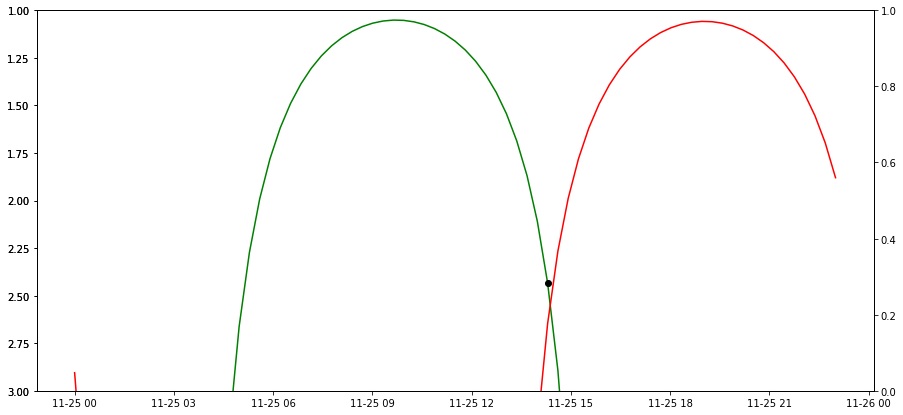

In [16]:
#Plotting 
fig, ax = plt.subplots(figsize=(15,7))
ax.invert_yaxis()
ax.set_ylim([3,1])
ax2 = ax.twinx()
ax.plot(dt_datetime, masked_airmass_ctio, '-',label='airmass@ctio', color='g')
ax2.plot(dt_datetime, masked_airmass_kmtnet, '-',color='r')
ax2.set_ylim([3,1])
ax3=ax2.twinx()


#plotting intersect
ax.plot(dt_datetime[ndx], masked_airmass_ctio[ndx], 'ko')


In [17]:


#Creating a dictionary for the dataframe
d={'datetimes':dt_datetime,'ctio-airmass':masked_airmass_ctio,'kmtnet-airmass':masked_airmass_kmtnet}

#Creating a dataframe
df=pd.DataFrame(data=d)   

df=df.round(3 )# Rounding up values 
 # Dropping NaN values but maintaining indexes in case there are NANs

df=df.dropna()#Checking the dataframe
df

,datetimes,ctio-airmass,kmtnet-airmass
41,2020-11-25 12:44:35.675676,1.431,23.880
42,2020-11-25 13:03:14.594595,1.544,9.093
43,2020-11-25 13:21:53.513514,1.687,5.616
44,2020-11-25 13:40:32.432432,1.869,4.070
45,2020-11-25 13:59:11.351351,2.109,3.201
46,2020-11-25 14:17:50.270270,2.434,2.647
47,2020-11-25 14:36:29.189189,2.893,2.266
48,2020-11-25 14:55:08.108108,3.587,1.989
49,2020-11-25 15:13:47.027027,4.744,1.781
50,2020-11-25 15:32:25.945946,7.037,1.620


In [18]:

covis_list=df.loc[(df['ctio-airmass']<3)&(df['ctio-airmass']>1)&((df['kmtnet-airmass']<3))&(df['kmtnet-airmass']>1)]


In [19]:
covis_list.reset_index(drop=True, inplace=True)
covis_list

,datetimes,ctio-airmass,kmtnet-airmass
0,2020-11-25 14:17:50.270270,2.434,2.647
1,2020-11-25 14:36:29.189189,2.893,2.266


In [21]:
cvs=covis_list['datetimes'][0]



cvd=covis_list['datetimes'][len(covis_list)-1]
print(cvs,'and',cvd)

2020-11-25 14:17:50.270270 and 2020-11-25 14:36:29.189189


In [22]:
#Calculating co visibility time in minutes
date_1=cvs

date_2=cvd

# returns a timedelta object 
delta = date_2-date_1
print('Difference: ', delta) 
  
mins = delta.total_seconds() / 60
print('Total difference in minutes: ',str(mins) + ' '+'mins') 

print('Total time co-observable in minutes: ',str(mins) + ' '+'mins')


Difference:  0 days 00:18:38.918919
Total difference in minutes:  18.64864865 mins
Total time co-observable in minutes:  18.64864865 mins


In [23]:

dec_range= np.linspace(-90,91,360)

RA_range=np.arange(1,361,1)
#RA_range


#fig, ax = plt.subplots(figsize=(15,7))

#ax2 = ax.twinx()

#ax.set_yticks(dec_range)
#ax.set_xticks(RA_range)

#ax2.scatter(139.52354583,-12.09555278)

#ax.grid()

In [24]:
mins

18.64864865

In [25]:

Z = np.random.rand(10, 5)
tr=([0,10],[10,20],[20,30],[30,40],[40,50],[50,60],[60,70],[70,80])
tr

([0, 10], [10, 20], [20, 30], [30, 40], [40, 50], [50, 60], [60, 70], [70, 80])

NameError: name 'ax1' is not defined

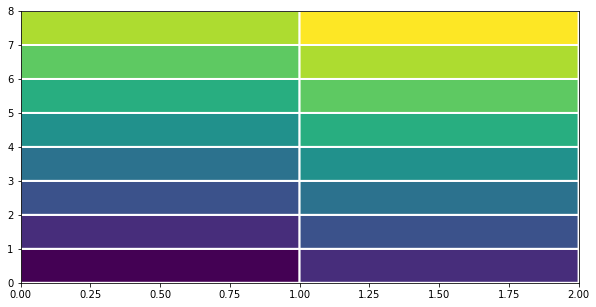

In [26]:


fig, (ax0) = plt.subplots(figsize=(10,5))

c = ax0.pcolor(tr, edgecolors='w', linewidths=2)#,cmap='RdBu'
ax1.set_title('thick edges')


fig.colorbar(c, ax=ax0,label='Co-visibilty time [Mins]')
fig.tight_layout()
plt.show()

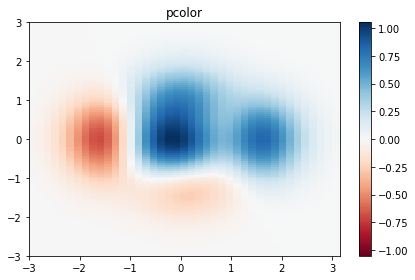

In [27]:
# make these smaller to increase the resolution
dx, dy = 0.15, 0.05

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-3, 3 + dy, dy),
                slice(-3, 3 + dx, dx)]
z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, axs = plt.subplots()

ax = axs
c = ax.pcolor(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolor')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=axs)


fig.tight_layout()
plt.show()

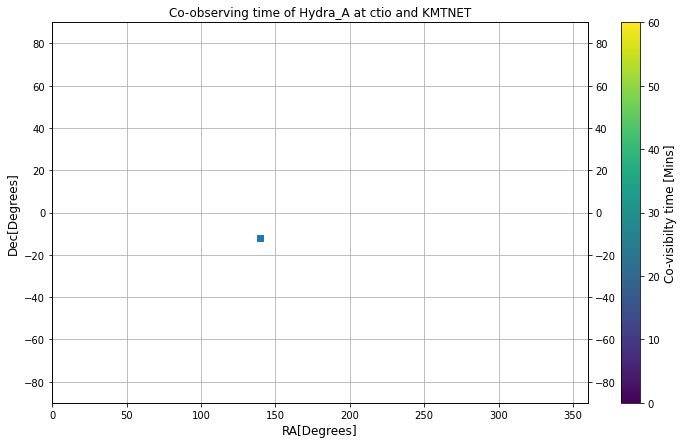

In [28]:

fig, ax = plt.subplots(figsize=(12,7))

sc = ax.scatter([139.52354583, -12.09555278],[139.52354583, -12.09555278], c=[0, 60])
ax.set_ylabel('Dec[Degrees]', loc='center',fontsize=12)
ax.set_xlabel('RA[Degrees]', loc='center',fontsize=12)
ax.set_ylim(-90,90)
ax.set_xlim(0,360)
ax.set_title('Co-observing time of'+' '+hydraA.name+ ' at '+ctio.name+ ' and '+kmtnet.name+'',fontsize=12)
ax.grid()


ax2 = ax.twinx()
ax2.scatter(hydraA.ra.deg, hydraA.dec.deg,marker=',')
ax2.set_ylim(-90,90)
cbar = fig.colorbar(sc)
cbar.set_label('Co-visibilty time [Mins]', loc='center',fontsize=12)

plt.show()


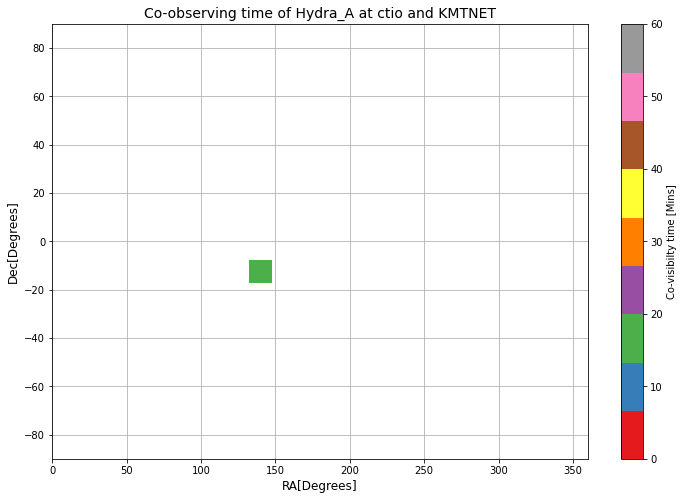

In [86]:
plt.figure(figsize=(12,8))

plt.ylabel('Dec[Degrees]', loc='center',fontsize=12)
plt.xlabel('RA[Degrees]', loc='center',fontsize=12)
x = hydraA.ra.deg
y = hydraA.dec.deg
colors = mins

plt.title('Co-observing time of'+' '+hydraA.name+ ' at '+ctio.name+ ' and '+kmtnet.name+'',fontsize=14)
plt.ylim(-90,90)
plt.xlim(0,360)
s=[500]
c=plt.scatter(x, y,s, c=colors, alpha=4.9,marker=',', cmap='Set1')


plt.clim(0,60)

plt.colorbar(label='Co-visibilty time [Mins]');  # show color scale
#ticks=range(60)
plt.grid()

In [ ]:
# make these smaller to increase the resolution
dx, dy = 0.15, 0.05

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-3, 3 + dy, dy),
                slice(-3, 3 + dx, dx)]
z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, axs = plt.subplots()

ax = axs
c = ax.pcolor(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolor')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)


fig.tight_layout()
plt.show()